In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import os
os.chdir("E:\code")
os.getcwd()

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)
X = tf.placeholder(tf.float32, [None, 28 * 28]) # MNIST = 28*28
Z = tf.placeholder(tf.float32, [None, 128]) # Noise Dimension = 128


Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [2]:
# ********* G-Network (Hidden Node # = 256)
G_W1 = tf.Variable(tf.random_normal([128, 256], stddev=0.01))
G_W2 = tf.Variable(tf.random_normal([256, 28 * 28], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([256]))
G_b2 = tf.Variable(tf.zeros([28 * 28]))

def generator(noise_z): # 128 -> 256 -> 28*28
    hidden = tf.nn.relu(tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, G_W2) + G_b2)
    return output

# ********* D-Network (Hidden Node # = 256)
D_W1 = tf.Variable(tf.random_normal([28 * 28, 256], stddev=0.01))
D_W2 = tf.Variable(tf.random_normal([256, 1], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([256]))
D_b2 = tf.Variable(tf.zeros([1]))

def discriminator(inputs): # 28*28 -> 256 -> 1
    hidden = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(tf.matmul(hidden, D_W2) + D_b2)
    return output

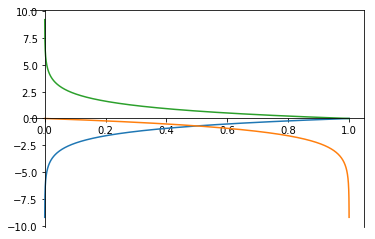

In [3]:
G = generator(Z)
loss_D = -tf.reduce_mean(tf.log(discriminator(X)) + tf.log(1 - discriminator(G)))
loss_G = -tf.reduce_mean(tf.log(discriminator(G)))
train_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=[D_W1, D_b1, D_W2, D_b2])
train_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=[G_W1, G_b1, G_W2, G_b2])

# x = discriminator(G)
# 0<x<1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x=np.arange(0.0001,1,0.0001)
y=np.log(x)
z=np.log(1-x)
w=-y
plt.plot(x,y)
plt.plot(x,z)
plt.plot(x,w)
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
# log(x) 가 log(1-x) 보다 0~1사이에서 초반에 더 강한 gradient를 줘서 학습속도롤 높일 수 있다.


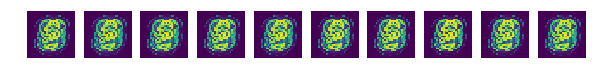

Epoch: 0000 D loss: 0.5529 G loss: 2.09


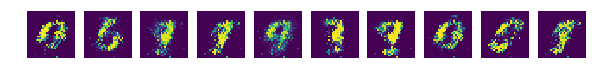

Epoch: 0009 D loss: 0.2201 G loss: 3.324


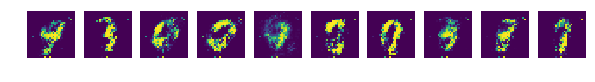

Epoch: 0019 D loss: 0.3386 G loss: 2.547


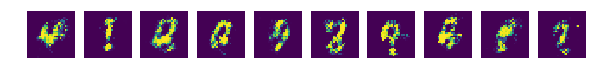

Epoch: 0029 D loss: 0.6999 G loss: 2.445


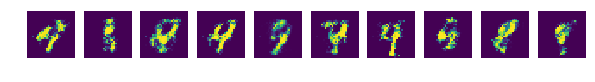

Epoch: 0039 D loss: 0.5276 G loss: 2.433


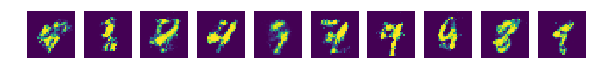

Epoch: 0049 D loss: 0.5771 G loss: 2.38


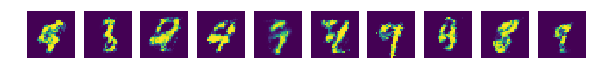

Epoch: 0059 D loss: 0.5481 G loss: 2.241


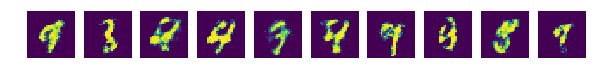

Epoch: 0069 D loss: 0.751 G loss: 2.104


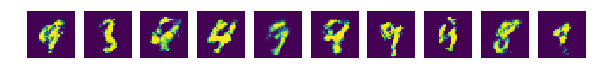

Epoch: 0079 D loss: 0.6187 G loss: 2.181


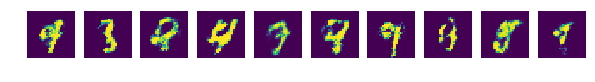

Epoch: 0089 D loss: 0.6044 G loss: 2.286


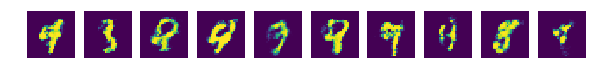

Epoch: 0099 D loss: 0.6446 G loss: 2.153


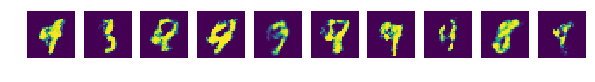

Epoch: 0109 D loss: 0.5609 G loss: 2.413


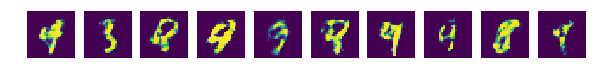

Epoch: 0119 D loss: 0.6792 G loss: 2.264


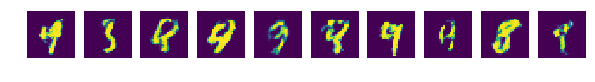

Epoch: 0129 D loss: 0.4937 G loss: 2.593


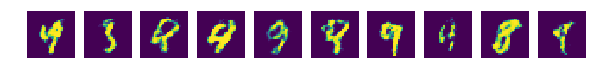

Epoch: 0139 D loss: 0.4659 G loss: 2.434


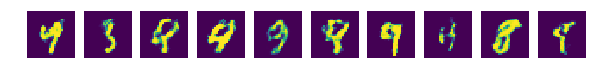

Epoch: 0149 D loss: 0.5006 G loss: 2.648


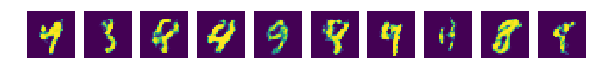

Epoch: 0159 D loss: 0.4939 G loss: 2.651


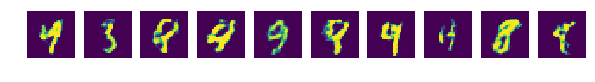

Epoch: 0169 D loss: 0.5087 G loss: 2.575


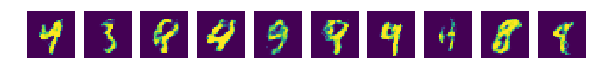

Epoch: 0179 D loss: 0.3851 G loss: 2.756


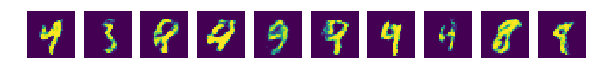

Epoch: 0189 D loss: 0.4863 G loss: 2.797


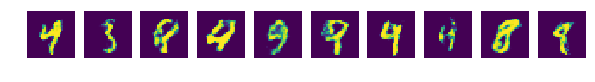

Epoch: 0199 D loss: 0.4958 G loss: 2.575


In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_val_D, loss_val_G = 0, 0
losses = []
# ********* Training and Testing
noise_test = np.random.normal(size=(10, 128)) # 10 = Test Sample Size, 128 = Noise Dimension
for epoch in range(200): # 200 = Num. of Epoch
    for i in range(int(mnist.train.num_examples / 100)): # 100 = Batch Size
        batch_xs, _ = mnist.train.next_batch(100)
        noise = np.random.normal(size=(100, 128))

        _, loss_val_D= sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G= sess.run([train_G, loss_G], feed_dict={Z: noise})

    if epoch == 0 or (epoch + 1) % 10 == 0: # 10 = Saving Period
        samples = sess.run(G, feed_dict={Z: noise_test})

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))
        
        plt.savefig('{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.show(fig)
        print('Epoch:', '%04d' % epoch,
              'D loss: {:.4}'.format(loss_val_D),
              'G loss: {:.4}'.format(loss_val_G))
    losses.append((loss_val_D, loss_val_G))    
    


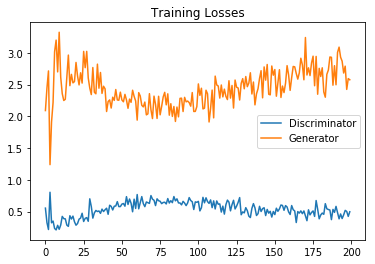

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

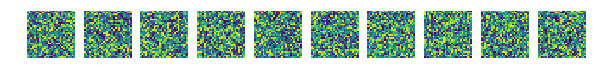